## 爬取租房信息(上海徐汇康健区)

In [ ]:
from selenium import webdriver    #最后rent
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common import NoSuchElementException, TimeoutException
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import re
import time
import random

In [ ]:
def crawl_target_rent_data(url, total_pages=20):
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.maximize_window()
    all_data = []
    current_page = 1
    
    try:
        while current_page <= total_pages:
            print(f"\n===== 开始爬取第 {current_page} 页 =====")
            driver.get(f"{url}i3{current_page}/" if current_page > 1 else url)
            time.sleep(random.uniform(4, 6))  # 随机等待降低反爬风险
            
            try:
                popup_selectors = ['span.popup-close', 'button.close', 'a.close', 'div.close']
                for selector in popup_selectors:
                    try:
                        close_btn = WebDriverWait(driver, 3).until(
                            EC.element_to_be_clickable((By.CSS_SELECTOR, selector))
                        )
                        close_btn.click()
                        time.sleep(2)
                        break
                    except TimeoutException:
                        continue
            except Exception as e:
                print(f"处理弹窗时出错: {e}")
            
            # 定位租房列表容器
            try:
                house_container = WebDriverWait(driver, 15).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, 'div.houseList'))
                )
            except TimeoutException:
                print("无法定位租房列表容器，跳过当前页")
                current_page += 1
                continue
            
            # 定位所有租房卡片（class为list hiddenMap rel）
            house_cards = house_container.find_elements(By.CSS_SELECTOR, 'dl.list.hiddenMap.rel')
            print(f"第 {current_page} 页找到{len(house_cards)}条租房卡片")
            
            for index, card in enumerate(house_cards):
                rent_info = {}
                valid_data = True  # 标记当前卡片是否有效
                
                #提取class为font15 mt12 bold的第三个数据
                font15_data = None
                try:
                    font15_ele = card.find_element(By.CSS_SELECTOR, 'p.font15.mt12.bold')
                    font15_text = font15_ele.text.strip()
                    if font15_text:
                        parts = re.split(r'[\s|/·]+', font15_text)
                        if len(parts) >= 3:
                            font15_data = parts[2].strip()
                        else:
                            valid_data = False
                except NoSuchElementException:
                    valid_data = False
                except Exception as e:
                    valid_data = False
                
                #提取class为gray6 mt12的数据
                gray6_mt12_data = None
                try:
                    gray6_mt12_ele = card.find_element(By.CSS_SELECTOR, 'p.gray6.mt12')
                    gray6_mt12_data = gray6_mt12_ele.text.strip()
                except NoSuchElementException:
                    valid_data = False
                except Exception as e:
                    valid_data = False
                
                # 提取class为mt5 alingC的数据
                mt5_alingC_data = None
                try:
                    mt5_alingC_ele = card.find_element(By.CSS_SELECTOR, 'p.mt5.alingC')
                    mt5_alingC_data = mt5_alingC_ele.text.strip()
                except NoSuchElementException:
                    valid_data = False
                except Exception as e:
                    valid_data = False
                
                # 仅当所有字段都有效时，才保存当前卡片数据
                if valid_data:
                    rent_info = {
                        '原始页码': current_page,
                        'font15_mt12_bold_第三个数据': font15_data,
                        'gray6_mt12数据': gray6_mt12_data,
                        'mt5_alingC数据': mt5_alingC_data
                    }
                    all_data.append(rent_info)
                else:
                    print(f"第 {current_page} 页 租房 {index+1}: 数据不完整，跳过")
            
            # 翻页
            current_page += 1
            if current_page <= total_pages:
                wait_time = random.uniform(3, 5)
                print(f"等待 {wait_time:.1f} 秒后翻页到第 {current_page} 页...")
                time.sleep(wait_time)
        
        # 数据汇总与重新编号
        df = pd.DataFrame(all_data)
        if not df.empty:
            df.insert(0, '序号', range(1, len(df) + 1))
            print(f"共爬取 {len(df)} 条有效租房数据（{total_pages}页）")
        return df
    
    except Exception as e:
        print(f"爬取过程出错：{str(e)}")
        df = pd.DataFrame(all_data)
        if not df.empty:
            df.insert(0, '序号', range(1, len(df) + 1))
        return df
    
    finally:
        driver.quit()
        print("浏览器已关闭")

In [ ]:
# 执行爬取操作c
url = "https://sh.zu.fang.com/house-a019-b01614/"
df = crawl_target_rent_data(url, total_pages=20)

if not df.empty:
    print("\n爬取结果预览：")
    print(df.head())
    df.to_csv("rent_data_20pages1.csv", index=False, encoding='utf-8-sig')
    print("\n数据已保存为 rent_data_20pages1.csv")
else:
    print("\n未提取到有效数据")

2025-10-14 02:59:38,952 - INFO - ====== WebDriver manager ======
2025-10-14 02:59:39,975 - INFO - Get LATEST chromedriver version for google-chrome
2025-10-14 02:59:40,262 - INFO - Get LATEST chromedriver version for google-chrome
2025-10-14 02:59:40,549 - INFO - Driver [C:\Users\activ\.wdm\drivers\chromedriver\win64\140.0.7339.207\chromedriver-win32/chromedriver.exe] found in cache



===== 开始爬取第 1 页 =====
成功定位租房列表容器
第 1 页找到60条租房卡片
等待 3.6 秒后翻页到第 2 页...

===== 开始爬取第 2 页 =====
成功定位租房列表容器
第 2 页找到60条租房卡片
等待 3.9 秒后翻页到第 3 页...

===== 开始爬取第 3 页 =====
成功定位租房列表容器
第 3 页找到60条租房卡片
等待 4.9 秒后翻页到第 4 页...

===== 开始爬取第 4 页 =====
成功定位租房列表容器
第 4 页找到60条租房卡片
等待 4.6 秒后翻页到第 5 页...

===== 开始爬取第 5 页 =====
成功定位租房列表容器
第 5 页找到60条租房卡片
等待 3.6 秒后翻页到第 6 页...

===== 开始爬取第 6 页 =====
成功定位租房列表容器
第 6 页找到60条租房卡片
等待 3.2 秒后翻页到第 7 页...

===== 开始爬取第 7 页 =====
成功定位租房列表容器
第 7 页找到60条租房卡片
等待 3.5 秒后翻页到第 8 页...

===== 开始爬取第 8 页 =====
成功定位租房列表容器
第 8 页找到60条租房卡片
等待 3.9 秒后翻页到第 9 页...

===== 开始爬取第 9 页 =====
成功定位租房列表容器
第 9 页找到60条租房卡片
等待 4.1 秒后翻页到第 10 页...

===== 开始爬取第 10 页 =====
成功定位租房列表容器
第 10 页找到60条租房卡片
等待 4.1 秒后翻页到第 11 页...

===== 开始爬取第 11 页 =====
成功定位租房列表容器
第 11 页找到60条租房卡片
等待 3.6 秒后翻页到第 12 页...

===== 开始爬取第 12 页 =====
成功定位租房列表容器
第 12 页找到60条租房卡片
等待 4.1 秒后翻页到第 13 页...

===== 开始爬取第 13 页 =====
成功定位租房列表容器
第 13 页找到60条租房卡片
等待 4.5 秒后翻页到第 14 页...

===== 开始爬取第 14 页 =====
成功定位租房列表容器
第 14 页找到60条租房卡片
等待 4.0 秒后翻页到第 15 页...

===

## 爬取卖房信息(上海徐汇康健区)

In [ ]:
from selenium import webdriver     #最后house
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common import NoSuchElementException, TimeoutException
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import re
import time
import random

In [ ]:
def crawl_target_house_data(url, total_pages=20):
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.maximize_window()
    all_data = []  # 存储所有页面的有效数据
    current_page = 1
    
    try:
        while current_page <= total_pages:
            print(f"\n===== 开始爬取第 {current_page} 页 =====") 
            page_url = f"{url}i3{current_page}/" if current_page > 1 else url   # 拼接分页URL（房天下分页规则：第n页加i3n/）
            driver.get(page_url)
            time.sleep(random.uniform(4, 6))  # 随机等待，降低反爬风险
            
            # 处理弹窗
            try:
                popup_selectors = ['span.popup-close', 'button.close', 'a.close', 'div.close']
                for selector in popup_selectors:
                    try:
                        close_btn = WebDriverWait(driver, 3).until(
                            EC.element_to_be_clickable((By.CSS_SELECTOR, selector))
                        )
                        close_btn.click()
                        time.sleep(2)
                        break
                    except TimeoutException:
                        continue
            except Exception as e:
                print(f"处理弹窗时出错: {e}")
            
            # 定位房源列表容器
            try:
                house_container = WebDriverWait(driver, 15).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, 'div.shop_list.shop_list_4'))  #列表容器为shop_list.shop_list_4
                )
                print("成功定位房源列表容器")
            except TimeoutException:
                print("无法定位房源列表容器，跳过当前页")
                current_page += 1
                continue
            
            # 定位所有房源卡片（定位dl.clearfix标签，避免混入其他元素）
            house_cards = house_container.find_elements(By.CSS_SELECTOR, 'dl.clearfix')
            print(f"第 {current_page} 页找到{len(house_cards)}条房源卡片")
            
            # 遍历每条卡片，严格校验字段关联性
            for card_idx, card in enumerate(house_cards):
                card_data = {
                    '原始页码': current_page,
                    'tel_shop_area(含单位)': pd.NA,
                    'add_shop': pd.NA,
                    'price_right_second(含单位)': pd.NA,
                    'red': pd.NA
                }
                is_valid = False
                core_fields_count = 0  # 面积、地址、价格）计数
                
                # 提取tel_shop的第二个数据（面积及单位）
                try:
                    # 遍历所有可能的tel_shop选择器，确保找到正确元素
                    tel_selectors = ['p.tel_shop', 'div.tel_shop', 'span.tel_shop']
                    tel_text = None
                    for sel in tel_selectors:
                        try:
                            tel_ele = card.find_element(By.CSS_SELECTOR, sel)
                            tel_text = tel_ele.text.strip()
                            if tel_text:
                                break  # 找到非空文本则停止尝试
                        except NoSuchElementException:
                            continue
                    
                    # 分割文本并提取第二个数据（面积）
                    if tel_text:
                        tel_parts = re.split(r'[\s|/·，,]+', tel_text)  # 兼容更多分隔符
                        if len(tel_parts) >= 2:
                            card_data['tel_shop_area(含单位)'] = tel_parts[1].strip()
                            core_fields_count += 1  # 核心字段+1
                except Exception as e:
                    print(f"第{current_page}页-卡片{card_idx+1}：解析tel_shop出错：{str(e)}")
                
                # 提取add_shop（地址）
                try:
                    add_selectors = ['p.add_shop', 'div.add_shop', 'span.add_shop', 'a.add_shop']
                    add_text = None
                    for sel in add_selectors:
                        try:
                            add_ele = card.find_element(By.CSS_SELECTOR, sel)
                            add_text = add_ele.text.strip()
                            if add_text:
                                break
                        except NoSuchElementException:
                            continue
                    
                    if add_text:
                        card_data['add_shop'] = add_text
                        core_fields_count += 1  # 字段+1
                except Exception as e:
                    print(f"第{current_page}页-卡片{card_idx+1}：解析add_shop出错：{str(e)}")
                
                # 提取price_right的第二个数据（价格）
                try:
                    price_ele = None
                    # 先尝试dd.price_right，再尝试div.price_right
                    try:
                        price_ele = card.find_element(By.CSS_SELECTOR, 'dd.price_right')
                    except NoSuchElementException:
                        price_ele = card.find_element(By.CSS_SELECTOR, 'div.price_right')
                    
                    price_text = price_ele.text.strip()
                    if price_text:
                        price_parts = re.split(r'[\s|/·，,]+', price_text)
                        if len(price_parts) >= 2:
                            card_data['price_right_second(含单位)'] = price_parts[1].strip()
                            core_fields_count += 1  # 字段+1
                except NoSuchElementException:
                    print(f"第{current_page}页-卡片{card_idx+1}：未找到price_right元素")
                except Exception as e:
                    print(f"第{current_page}页-卡片{card_idx+1}：解析price_right出错：{str(e)}")
                
                # 提取red(价格)
                try:
                    red_ele = card.find_element(By.CSS_SELECTOR, 'span.red')
                    red_text = red_ele.text.strip()
                    if red_text:
                        card_data['red'] = red_text
                except NoSuchElementException:
                    try:
                        red_ele = card.find_element(By.CSS_SELECTOR, 'font.red')
                        red_text = red_ele.text.strip()
                        if red_text:
                            card_data['red'] = red_text
                    except NoSuchElementException:
                        pass 
                except Exception as e:
                    print(f"第{current_page}页-卡片{card_idx+1}：解析red出错：{str(e)}")
                
                if core_fields_count >= 2:
                    is_valid = True
                    all_data.append(card_data)
                    # 调试信息：仅显示有效数据
                    print(f"第{current_page}页-卡片{card_idx+1}：")
                    print(f"  面积：{card_data['tel_shop_area(含单位)']} | 地址：{card_data['add_shop']} | 价格项：{card_data['price_right_second(含单位)']} | 红色标签：{card_data['red']}")
                else:
                    print(f"第{current_page}页-卡片{card_idx+1}：核心字段仅{core_fields_count}个，跳过")
            
            # 翻页
            current_page += 1
            if current_page <= total_pages:
                wait_time = random.uniform(3, 5)
                print(f"等待 {wait_time:.1f} 秒后翻页到第 {current_page} 页...")
                time.sleep(wait_time)
        
        # 数据汇总：重新编号，过滤完全空行
        df = pd.DataFrame(all_data)
        if not df.empty:
            # 添加从1开始的连续序号（覆盖原始索引）
            df.insert(0, '序号', range(1, len(df) + 1))
            df = df.dropna(how='all', subset=['tel_shop_area(含单位)', 'add_shop', 'price_right_second(含单位)'])
            print(f"\n===== 爬取完成 =====")
            print(f"共爬取 {len(df)} 条有效房源数据（{total_pages}页，过滤无效卡片）")
        else:
            df = pd.DataFrame()
            print(f"\n===== 爬取完成 =====")
            print(f"未获取到有效房源数据（{total_pages}页）")
        return df
    
    except Exception as e:
        print(f"爬取过程出错：{str(e)}")
        # 若出错，也返回已爬取的有效数据
        df = pd.DataFrame(all_data)
        if not df.empty:
            df.insert(0, '序号', range(1, len(df) + 1))
            df = df.dropna(how='all', subset=['tel_shop_area(含单位)', 'add_shop', 'price_right_second(含单位)'])
        return df
    
    finally:
        # 浏览器关闭
        driver.quit()

In [ ]:
# 执行爬取
url = "https://sh.esf.fang.com/house-a019-b01614/"
df = crawl_target_house_data(url, total_pages=20)

# 结果处理：显示+保存
if not df.empty:
    print("\n爬取结果预览（前5条）：")
    preview_cols = ['序号', '原始页码', 'tel_shop_area', 'add_shop', 'price_right_second']
    print(df[preview_cols].head())
    
    # 保存为CSV（兼容Excel）
    df.to_csv("house_data_20pages1.csv", index=False, encoding='utf-8-sig')
    print("\n数据已保存为：")
    print("1. house_data_20pages1.csv")
else:
    print("\n未提取到有效数据，请检查页面结构或网络连接")

2025-10-14 03:20:53,460 - INFO - ====== WebDriver manager ======
2025-10-14 03:20:54,487 - INFO - Get LATEST chromedriver version for google-chrome
2025-10-14 03:20:54,777 - INFO - Get LATEST chromedriver version for google-chrome
2025-10-14 03:20:55,060 - INFO - Driver [C:\Users\activ\.wdm\drivers\chromedriver\win64\140.0.7339.207\chromedriver-win32/chromedriver.exe] found in cache



===== 开始爬取第 1 页 =====
成功定位房源列表容器
第 1 页找到60条房源卡片
第1页-卡片1（有效）：
  面积：106.43㎡ | 地址：海上名门
康健 柳州路181弄 | 价格项：108052元 | 红色标签：1150万
第1页-卡片2（有效）：
  面积：111.79㎡ | 地址：漕河景苑
康健 康健路58弄 | 价格项：118078元 | 红色标签：1320万
第1页-卡片3（有效）：
  面积：58.71㎡ | 地址：薛家宅小区
康健 冠生园路230弄 | 价格项：55356元 | 红色标签：325万
第1页-卡片4（有效）：
  面积：42.55㎡ | 地址：花苑村紫竹园
康健 浦北路948弄 | 价格项：48883元 | 红色标签：208万
第1页-卡片5（有效）：
  面积：57.41㎡ | 地址：长海坊
康健 桂林西街9弄 | 价格项：54694元 | 红色标签：314万
第1页-卡片6（有效）：
  面积：44.9㎡ | 地址：长海坊
康健 桂林西街9弄 | 价格项：57015元 | 红色标签：256万
第1页-卡片7（有效）：
  面积：78.85㎡ | 地址：桂平小区
康健 桂平小区 | 价格项：54533元 | 红色标签：430万
第1页-卡片8（有效）：
  面积：97.32㎡ | 地址：漕河景苑
康健 康健路58弄 | 价格项：112823元 | 红色标签：1098万
第1页-卡片9（有效）：
  面积：43.54㎡ | 地址：花苑村紫竹园
康健 浦北路948弄 | 价格项：48690元 | 红色标签：212万
第1页-卡片10（有效）：
  面积：52.29㎡ | 地址：寿昌坊
康健 桂林西街151弄 | 价格项：62153元 | 红色标签：325万
第1页-卡片11（有效）：
  面积：131.69㎡ | 地址：圣骊家园
康健 沪闵路9116号、沪闵路9120号 | 价格项：68190元 | 红色标签：898万
第1页-卡片12（有效）：
  面积：113.7㎡ | 地址：沪华公寓
康健 冠生园路20号 | 价格项：51890元 | 红色标签：590万
第1页-卡片13（有效）：
  面积：129.59㎡ | 地址：中星海上华庭
康健 虹漕南路699弄 | 价格项：67134元 | 红色标签：870万
第1页-卡

### 获取小组全部数据并提前修改统一列名

## 合并卖房信息并提取删除异常值

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import chardet

In [8]:
df_kangjian = pd.read_csv('C:/Users/activ/Desktop/康健house_data.csv', encoding='gb18030')  #该csv文件的编码为'gb18030'
df_longhua = pd.read_csv('C:/Users/activ/Desktop/徐汇龙华price_data.csv')
excel_file = pd.ExcelFile('C:/Users/activ/Desktop/徐家汇卖价.xlsx')  #徐家汇为xlsx文件
df_xujiahui = excel_file.parse('Sheet1')

# 添加所在街区列
df_kangjian['所在街区'] = '康健'
df_longhua['所在街区'] = '龙华'
df_xujiahui['所在街区'] = '徐家汇'

In [9]:
required_columns = ['面积', '总价', '单价', '所在街区']
for df in [df_kangjian, df_longhua, df_xujiahui]:
    for col in required_columns:
        if col not in df.columns:
            df[col] = None  # 为缺失的列创建空值列

# 提取
df_kangjian = df_kangjian[required_columns]
df_longhua = df_longhua[required_columns]
df_xujiahui = df_xujiahui[required_columns]

# 合并数据
combined_df = pd.concat([df_kangjian, df_longhua, df_xujiahui], ignore_index=True)

In [10]:
# 定义单位转换函数
def convert_to_numeric(value, column_type):
    if pd.isna(value):
        return None
    
    # 转换为字符串并删去空格，保留数字
    str_val = str(value).strip()
    numeric_part = ''.join([c for c in str_val if c.isdigit() or c == '.'])
    if not numeric_part:
        return None
    
    # 根据列类型处理单位
    if column_type == '总价':
        if '万' in str_val:
            return float(numeric_part) * 10000
        else:
            return float(numeric_part)
    elif column_type == '面积':
        return float(numeric_part)
    elif column_type == '单价':
        return float(numeric_part)
    return None

In [15]:
# 应用函数
combined_df['面积'] = combined_df['面积'].apply(lambda x: convert_to_numeric(x, '面积'))
combined_df['总价'] = combined_df['总价'].apply(lambda x: convert_to_numeric(x, '总价'))
combined_df['单价'] = combined_df['单价'].apply(lambda x: convert_to_numeric(x, '单价'))

# 数据描述，并保留两位小数
description = combined_df[['面积', '总价', '单价']].describe().round(2)
print('\n数据描述：')
print(description)

# 保存合并后的数据
combined_df.to_csv("combined_house.csv", index=False, encoding='utf-8-sig')


数据描述：
            面积            总价         单价
count  3600.00  3.600000e+03    3600.00
mean    106.44  9.883262e+06   83011.71
std      58.29  9.179495e+06   30062.48
min       3.00  1.480000e+06   32554.00
25%      63.82  3.980000e+06   60954.00
50%      99.16  7.750000e+06   78918.00
75%     135.17  1.250000e+07   97798.50
max     476.89  1.088800e+08  228312.00


In [17]:
# 检测单价异常值
if not combined_df['单价'].dropna().empty:
    Q1 = combined_df['单价'].quantile(0.25)
    Q3 = combined_df['单价'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 删除异常值
    combined_df_cleaned1 = combined_df[
        (combined_df['单价'].isna()) |  
        ((combined_df['单价'] >= lower_bound) & (combined_df['单价'] <= upper_bound))  
    ].reset_index(drop=True)  # 重置索引，避免删除后索引断层

else:
    combined_df_cleaned1 = combined_df.copy() #保留原始数据

# 检测面积异常值
if not combined_df_cleaned1['面积'].dropna().empty:
    Q1 = combined_df_cleaned1['面积'].quantile(0.25)
    Q3 = combined_df_cleaned1['面积'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 删除异常值
    combined_df_cleaned2 = combined_df_cleaned1[
        (combined_df_cleaned1['面积'].isna()) |  
        ((combined_df_cleaned1['面积'] >= lower_bound) & (combined_df_cleaned1['面积'] <= upper_bound))  
    ].reset_index(drop=True)  # 重置索引，避免删除后索引断层

else:
    combined_df_cleaned2 = combined_df_cleaned1.copy()
    print('\n没有可用的单价数据进行异常值分析，保留原始数据')

# 保存删除异常值后的清洗数据
combined_df_cleaned2.to_csv("combined_house_cleaned2.csv", index=False, encoding='utf-8-sig')
print('已保存清洗后的卖房数据至 combined_house_cleaned2.csv')

已保存清洗后的卖房数据至 combined_house_cleaned2.csv


## 合并房租信息并提取异常值

In [7]:
import pandas as pd
df_kangjian = pd.read_csv('C:/Users/activ/Desktop/康健rent_data.csv', encoding='gb18030')  #该csv文件的编码为'gb18030'
df_longhua = pd.read_csv('C:/Users/activ/Desktop/徐汇龙华rent_data.csv', encoding='gb18030')
excel_file = pd.ExcelFile('C:/Users/activ/Desktop/徐家汇租房.xlsx')
df_xujiahui = excel_file.parse('Sheet1')

In [8]:
# 提取所在街区信息，并添加所在街区列
df_kangjian['所在街区'] = '康健'
df_longhua['所在街区'] = '龙华'
df_xujiahui['所在街区'] = '徐家汇'

# 提取需要的列
columns = ['面积', '月租', '所在街区']
df_kangjian = df_kangjian[columns]
df_longhua = df_longhua[columns]
df_xujiahui = df_xujiahui[columns]

# 合并三个数据
combined_df = pd.concat([df_kangjian, df_longhua, df_xujiahui], ignore_index=True)

In [9]:
# 定义函数去除单位并转换为数值类型
def convert_to_numeric(value):
    if isinstance(value, str):
        value = value.replace('㎡', '').replace('元/月', '')
        return pd.to_numeric(value, errors='coerce')
    return value

# 应用函数
combined_df['面积'] = combined_df['面积'].apply(convert_to_numeric)
combined_df['月租'] = combined_df['月租'].apply(convert_to_numeric)
combined_df = combined_df[['面积', '月租', '所在街区']]

# 进行数据描述
description = combined_df[['面积', '月租']].describe().round(2)
print('数据描述：')
print(description)

数据描述：
            面积         月租
count  3328.00    3328.00
mean    101.88   13285.62
std      87.76   18037.65
min      15.00    1500.00
25%      48.00    5000.00
50%      71.00    7350.00
75%     127.00   14500.00
max    1103.00  200000.00


In [10]:
# 检测月租异常值
Q1 = combined_df['月租'].quantile(0.25)
Q3 = combined_df['月租'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = combined_df[(combined_df['月租'] < lower_bound) | (combined_df['月租'] > upper_bound)]
print('月租的异常值：')
print(outliers)

# 保存数据
combined_df.to_csv("combined_rent.csv", index=False, encoding='utf-8-sig')
print('已保存清洗后的租房数据至 combined_rent.csv')

月租的异常值：
       面积      月租 所在街区
462   425  100000   康健
500   208   42000   康健
594   318   52000   康健
755   318   52000   康健
928   440  100000   龙华
...   ...     ...  ...
3302  184   30000  徐家汇
3304  189   35000  徐家汇
3310  226   39000  徐家汇
3319  225   29000  徐家汇
3325  320   55000  徐家汇

[286 rows x 3 columns]
已保存清洗后的租房数据至 combined_rent.csv


## 计算中位数，绘制租售比条形图

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

excel_file_sale = pd.ExcelFile('C:/Users/activ/Desktop/combined_house_cleaned2.xlsx')
df_sale = excel_file_sale.parse('combined_house_cleaned2')
excel_file_rent = pd.ExcelFile('C:/Users/activ/Desktop/combined_rent.xlsx')
df_rent = excel_file_rent.parse('combined_rent')

In [18]:
# 按所在街区分组，计算总价的中位数
sale_median = df_sale.groupby('所在街区')['总价'].median()

# 按所在街区分组，计算月租的中位数
rent_median = df_rent.groupby('所在街区')['月租'].median()

# 计算价格与租金比率的中位数
ratio_median = sale_median / rent_median

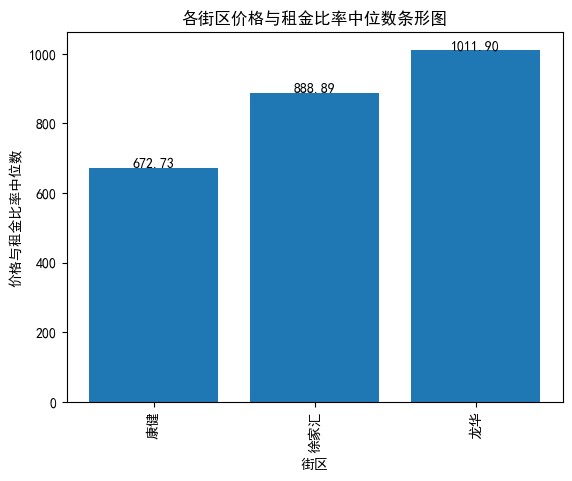

总价中位数：
 所在街区
康健     3700000.0
徐家汇    8800000.0
龙华     8500000.0
Name: 总价, dtype: float64
月租中位数：
 所在街区
康健     5500.0
徐家汇    9900.0
龙华     8400.0
Name: 月租, dtype: float64
价格与租金比率中位数：
 所在街区
康健      672.727273
徐家汇     888.888889
龙华     1011.904762
dtype: float64


In [19]:
# 绘制条形图
plt.rcParams["font.family"] = ["SimHei", "Microsoft YaHei"]
plt.bar(ratio_median.index, ratio_median)
plt.xlabel('街区')
plt.ylabel('价格与租金比率中位数')
plt.title('各街区价格与租金比率中位数条形图')
for i in range(len(ratio_median.index)):
    plt.text(i, ratio_median.iloc[i], f'{ratio_median.iloc[i]:.2f}', ha='center', size=10)
plt.xticks(rotation=90)
plt.show()

print('总价中位数：\n', sale_median)
print('月租中位数：\n', rent_median)
print('价格与租金比率中位数：\n', ratio_median)

## 模型构建及预测

### 使用模型一

In [7]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# 读取文件
excel_file = pd.ExcelFile('C:/Users/activ/Desktop/combined_house_cleaned2.xlsx')
df = excel_file.parse('combined_house_cleaned2')
df = df.dropna()

# 查看所有街区
unique_areas = df['所在街区'].unique()
print(f"所有街区类别: {unique_areas}")

# 设定第一个街区为基准街区
base_area = unique_areas[0]
area1 = unique_areas[1]
area2 = unique_areas[2]

# 创建0-1变量
# 对于基准街区，两个变量都为0
df[f'是否{area1}'] = (df['所在街区'] == area1).astype(int)  # 对于block1，第一个变量为1，第二个为0
df[f'是否{area2}'] = (df['所在街区'] == area2).astype(int)  # 对于block2，第一个变量为0，第二个为1

# 提取特征变量和目标变量
X = df[['面积', f'是否{area1}', f'是否{area2}']]
y = df['总价']

# 构建线性回归模型
model = LinearRegression()
model.fit(X, y)
# 使用模型进行预测
df['预测总价'] = model.predict(X)

# 保存
new_path = 'combined_house_cleaned2_predicted.xlsx'
df.to_excel(new_path, index=False)

# 输出模型系数
print(f"\n基准街区: {base_area}")
print("模型系数:")
print(f"截距 (β0): {model.intercept_}")
print(f"面积系数 (β1): {model.coef_[0]}")
print(f"{area1}系数 (β2): {model.coef_[1]}")
print(f"{area2}系数 (β3): {model.coef_[2]}")

print("\n编码后的数据预览:")
print(df[['面积', '所在街区', f'是否{area1}', f'是否{area2}', '预测总价']].head())

所有街区类别: ['龙华' '徐家汇' '康健']

基准街区: 龙华
模型系数:
截距 (β0): -948668.9327391852
面积系数 (β1): 106055.7417061502
徐家汇系数 (β2): -658932.8775375697
康健系数 (β3): -2828666.5297806626

编码后的数据预览:
      面积 所在街区  是否徐家汇  是否康健          预测总价
0  25.91   龙华      0     0  1.799235e+06
1  25.91   龙华      0     0  1.799235e+06
2  25.91   龙华      0     0  1.799235e+06
3  25.91   龙华      0     0  1.799235e+06
4  25.91   龙华      0     0  1.799235e+06


### 使用模型二

In [8]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# 读取文件
excel_file = pd.ExcelFile('C:/Users/activ/Desktop/combined_rent.xlsx')
df = excel_file.parse('combined_rent')

# 查看所有街区
unique_areas = df['所在街区'].unique()
print(f"所有街区类别: {unique_areas}")

# 设定第一个街区为基准街区
base_area = unique_areas[0]
area1 = unique_areas[1]
area2 = unique_areas[2]

# 创建0-1变量
# 对于基准街区，两个变量都为0
df[f'是否{area1}'] = (df['所在街区'] == area1).astype(int)
df[f'是否{area2}'] = (df['所在街区'] == area2).astype(int)

# 提取特征变量和目标变量
X = df[['面积', f'是否{area1}', f'是否{area2}']]
y = df['月租']

# 构建线性回归模型
model = LinearRegression()
model.fit(X, y)

# 使用模型进行预测
df['预测月租'] = model.predict(X)

# 保存结果
new_path = 'combined_rent_predicted.xlsx'
df.to_excel(new_path, index=False)

# 输出模型系数
print(f"\n基准街区: {base_area}")
print("模型系数:")
print(f"截距 (β0): {model.intercept_}")
print(f"面积系数 (β1): {model.coef_[0]}")
print(f"{area1}系数 (β2): {model.coef_[1]}")
print(f"{area2}系数 (β3): {model.coef_[2]}")

print("\n编码后的数据预览:")
print(df[['面积', '所在街区', f'是否{area1}', f'是否{area2}', '预测月租']].head())

所有街区类别: ['康健' '龙华' '徐家汇']

基准街区: 康健
模型系数:
截距 (β0): -4565.094876431798
面积系数 (β1): 167.0989971726189
龙华系数 (β2): 2149.2773109455775
徐家汇系数 (β3): 141.90941775162747

编码后的数据预览:
   面积 所在街区  是否龙华  是否徐家汇         预测月租
0  44   康健     0      0  2787.260999
1  34   康健     0      0  1116.271027
2  36   康健     0      0  1450.469022
3  37   康健     0      0  1617.568019
4  43   康健     0      0  2620.162002


## 计算预测后的中位数，重新绘制租售比条形图

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

excel_file_sale = pd.ExcelFile('C:/Users/activ/combined_house_cleaned2_predicted.xlsx')
df_sale = excel_file_sale.parse('Sheet1')
excel_file_rent = pd.ExcelFile('C:/Users/activ/combined_rent_predicted.xlsx')
df_rent = excel_file_rent.parse('Sheet1')

In [12]:
# 按所在街区分组，计算预测后的总价的中位数
sale_median_predicted = df_sale.groupby('所在街区')['预测总价'].median()

# 按所在街区分组，计算预测后的月租的中位数
rent_median_predicted = df_rent.groupby('所在街区')['预测月租'].median()

# 计算价格与租金比率的中位数
ratio_median_predicted = sale_median_predicted / rent_median_predicted
print(ratio_median_predicted.head())

所在街区
康健     759.497653
徐家汇    891.857967
龙华     967.139666
dtype: float64


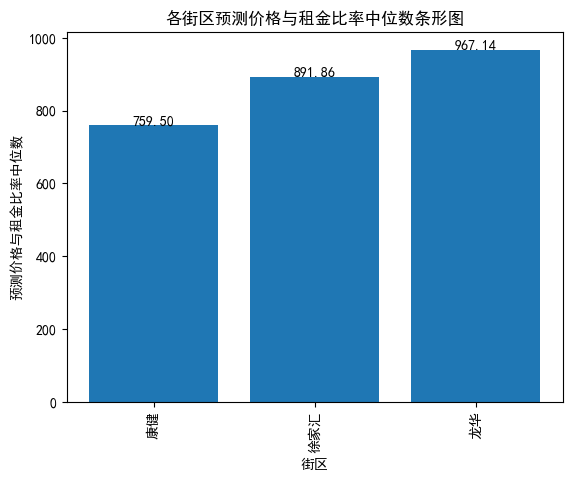

预测总价中位数：
 所在街区
康健     3.893676e+06
徐家汇    1.006383e+07
龙华     9.784172e+06
Name: 预测总价, dtype: float64
预测月租中位数：
 所在街区
康健      5126.646960
徐家汇    11284.120276
龙华     10116.607222
Name: 预测月租, dtype: float64
预测价格与租金比率中位数：
 所在街区
康健     759.497653
徐家汇    891.857967
龙华     967.139666
dtype: float64


In [11]:
# 绘制条形图
plt.rcParams["font.family"] = ["SimHei", "Microsoft YaHei"]
plt.bar(ratio_median_predicted.index, ratio_median_predicted)
plt.xlabel('街区')
plt.ylabel('预测价格与租金比率中位数')
plt.title('各街区预测价格与租金比率中位数条形图')
for i in range(len(ratio_median_predicted.index)):
    plt.text(i, ratio_median_predicted.iloc[i], f'{ratio_median_predicted.iloc[i]:.2f}', ha='center', size=10)
plt.xticks(rotation=90)
plt.show()

print('预测总价中位数：\n', sale_median_predicted)
print('预测月租中位数：\n', rent_median_predicted)
print('预测价格与租金比率中位数：\n', ratio_median_predicted)

## 模型1+

公式：总价 = β0 + β1×面积 + β2×面积平方 + β3×是否area1 + β4×是否area2 + β5×(面积×是否area1) + β6×(面积×是否area2) + ϵ

In [13]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# 读取文件
excel_file = pd.ExcelFile('C:/Users/activ/Desktop/combined_house_cleaned2.xlsx')
df = excel_file.parse('combined_house_cleaned2')
df = df.dropna()

# 查看所有街区
unique_areas = df['所在街区'].unique()
print(f"所有街区类别: {unique_areas}")

# 设定第一个街区为基准街区
base_area = unique_areas[0]
area1 = unique_areas[1]
area2 = unique_areas[2]

# 创建0-1变量
df[f'是否{area1}'] = (df['所在街区'] == area1).astype(int)
df[f'是否{area2}'] = (df['所在街区'] == area2).astype(int)

# 添加面积的平方项（非线性项）
df['面积平方'] = df['面积'] **2

# 添加交互项（面积与街区变量的交互）
df[f'面积_是否{area1}'] = df['面积'] * df[f'是否{area1}']
df[f'面积_是否{area2}'] = df['面积'] * df[f'是否{area2}']

# 提取特征变量（包含原始变量、非线性项和交互项）
X = df[
    ['面积', '面积平方', 
     f'是否{area1}', f'是否{area2}',
     f'面积_是否{area1}', f'面积_是否{area2}'
    ]
]
y = df['总价']

# 构建扩展后的线性回归模型（模型1+）
model = LinearRegression()
model.fit(X, y)

# 使用模型进行预测
df['预测总价_模型1+'] = model.predict(X)

# 保存结果
new_path = 'combined_house_cleaned2_predicted_with_interactions.xlsx'
df.to_excel(new_path, index=False)

# 输出模型系数
print(f"\n基准街区: {base_area}")
print("模型1+系数:")
print(f"截距 (β0): {model.intercept_}")
for i, feature in enumerate(X.columns):
    print(f"{feature} 系数 (β{i+1}): {model.coef_[i]}")

print("\n包含交互项的数据预览:")
print(df[['面积', '面积平方', '所在街区', 
         f'是否{area1}', f'是否{area2}',
         f'面积_是否{area1}', f'面积_是否{area2}',
         '预测总价_模型1+'
        ]].head())


所有街区类别: ['龙华' '徐家汇' '康健']

基准街区: 龙华
模型1+系数:
截距 (β0): -1283751.3268143013
面积 系数 (β1): 85441.27993812521
面积平方 系数 (β2): 192.05712839067135
是否徐家汇 系数 (β3): 2054754.3272748303
是否康健 系数 (β4): 1509558.763985851
面积_是否徐家汇 系数 (β5): -25301.2014419378
面积_是否康健 系数 (β6): -45476.720652287935

包含交互项的数据预览:
      面积      面积平方 所在街区  是否徐家汇  是否康健  面积_是否徐家汇  面积_是否康健     预测总价_模型1+
0  25.91  671.3281   龙华      0     0       0.0      0.0  1.058966e+06
1  25.91  671.3281   龙华      0     0       0.0      0.0  1.058966e+06
2  25.91  671.3281   龙华      0     0       0.0      0.0  1.058966e+06
3  25.91  671.3281   龙华      0     0       0.0      0.0  1.058966e+06
4  25.91  671.3281   龙华      0     0       0.0      0.0  1.058966e+06


## 模型 2+

月租 = β0 + β1×面积 + β2×面积平方 + β3×是否area1 + β4×是否area2 + β5×(面积×是否area1) + β6×(面积×是否area2) + ϵ

In [14]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# 读取文件
excel_file = pd.ExcelFile('C:/Users/activ/Desktop/combined_rent.xlsx')
df = excel_file.parse('combined_rent')

# 查看所有街区
unique_areas = df['所在街区'].unique()
print(f"所有街区类别: {unique_areas}")

# 设定第一个街区为基准街区
base_area = unique_areas[0]
area1 = unique_areas[1]
area2 = unique_areas[2]

# 创建0-1变量
df[f'是否{area1}'] = (df['所在街区'] == area1).astype(int)
df[f'是否{area2}'] = (df['所在街区'] == area2).astype(int)

# 添加面积的平方项（非线性项）
df['面积平方'] = df['面积'] **2

# 添加交互项（面积与街区变量的交互）
df[f'面积_是否{area1}'] = df['面积'] * df[f'是否{area1}']
df[f'面积_是否{area2}'] = df['面积'] * df[f'是否{area2}']

# 提取特征变量（包含原始变量、非线性项和交互项）
X = df[
    ['面积', '面积平方', 
     f'是否{area1}', f'是否{area2}',
     f'面积_是否{area1}', f'面积_是否{area2}'
    ]
]
y = df['月租']

# 构建扩展后的线性回归模型（模型2+）
model = LinearRegression()
model.fit(X, y)

# 使用模型进行预测
df['预测月租_模型2+'] = model.predict(X)

# 保存结果
new_path = 'combined_rent_predicted_with_interactions.xlsx'
df.to_excel(new_path, index=False)

# 输出模型系数
print(f"\n基准街区: {base_area}")
print("模型2+系数:")
print(f"截距 (β0): {model.intercept_}")
for i, feature in enumerate(X.columns):
    print(f"{feature} 系数 (β{i+1}): {model.coef_[i]}")

print("\n包含交互项的数据预览:")
print(df[['面积', '面积平方', '所在街区', 
         f'是否{area1}', f'是否{area2}',
         f'面积_是否{area1}', f'面积_是否{area2}',
         '预测月租_模型2+'
        ]].head())
    

所有街区类别: ['康健' '龙华' '徐家汇']

基准街区: 康健
模型2+系数:
截距 (β0): -1684.4958003029315
面积 系数 (β1): 128.39807673255422
面积平方 系数 (β2): -0.021923372775941037
是否龙华 系数 (β3): -2852.483671169681
是否徐家汇 系数 (β4): -2050.597917219866
面积_是否龙华 系数 (β5): 61.509818848415804
面积_是否徐家汇 系数 (β6): 36.248717283169476

包含交互项的数据预览:
   面积  面积平方 所在街区  是否龙华  是否徐家汇  面积_是否龙华  面积_是否徐家汇    预测月租_模型2+
0  44  1936   康健     0      0        0         0  3922.575926
1  34  1156   康健     0      0        0         0  2655.695390
2  36  1296   康健     0      0        0         0  2909.422271
3  37  1369   康健     0      0        0         0  3036.219941
4  43  1849   康健     0      0        0         0  3796.085183


## 重新计算Pro模型预测后的中位数，绘制租售比条形图

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

excel_file_sale = pd.ExcelFile('C:/Users/activ/combined_house_cleaned2_predicted_with_interactions.xlsx')
df_sale = excel_file_sale.parse('Sheet1')
excel_file_rent = pd.ExcelFile('C:/Users/activ/combined_rent_predicted_with_interactions.xlsx')
df_rent = excel_file_rent.parse('Sheet1')

In [21]:
# 按所在街区分组，计算预测后的总价的中位数
sale_median_predicted_pro = df_sale.groupby('所在街区')['预测总价_模型1+'].median()

# 按所在街区分组，计算预测后的月租的中位数
rent_median_predicted_pro = df_rent.groupby('所在街区')['预测月租_模型2+'].median()

# 计算价格与租金比率的中位数
ratio_median_predicted_pro = sale_median_predicted_pro / rent_median_predicted_pro
print(ratio_median_predicted_pro.head())

所在街区
康健     724.438353
徐家汇    841.308581
龙华     973.604353
dtype: float64


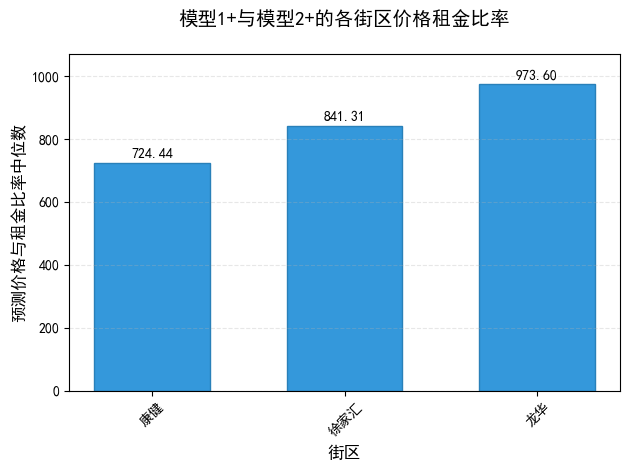

各街区租售比指标汇总
      预测总价pro中位数（元）  预测月租pro中位数（元）  价格租金比率pro中位数
所在街区                                            
康健          4121216           5689        724.44
徐家汇         9715423          11548        841.31
龙华          9329850           9583        973.60


In [26]:
plt.rcParams["font.family"] = ["SimHei", "Microsoft YaHei"]

fig, ax = plt.subplots()
bars = ax.bar(ratio_median_predicted_pro.index, ratio_median_predicted_pro.values, color='#3498db', width=0.6, edgecolor='#2980b9')

ax.set_xlabel('街区', fontsize=12, fontweight='bold')
ax.set_ylabel('预测价格与租金比率中位数', fontsize=12, fontweight='bold')
ax.set_title('模型1+与模型2+的各街区价格租金比率', fontsize=14, fontweight='bold', pad=20)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + max(ratio_median_predicted_pro)*0.01, 
            f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(ratio_median_predicted_pro)*1.1)
plt.tight_layout()
plt.savefig('price_rent_ratio.png', dpi=300)
plt.show()

# 输出分析结果
print("各街区租售比指标汇总")
result = pd.DataFrame({
    '预测总价pro中位数（元）': sale_median_predicted_pro.reindex(ratio_median_predicted_pro.index).round(0).astype(int),
    '预测月租pro中位数（元）': rent_median_predicted_pro.reindex(ratio_median_predicted_pro.index).round(0).astype(int),
    '价格租金比率pro中位数': ratio_median_predicted_pro.round(2)
})
print(result)

总结：观察上述两个模型得到的租售比图表，可知
两张图中 “龙华” 租售比最高、“康健” 最低，排序完全一致，说明两种模型对街区租售比的相对差异判断是稳定的。
模型 1+&2 + 的租售比数值（康健 724.44、徐家汇 841.31、龙华 973.60）整体略低于原始模型，但差异幅度较小（如龙华从 967.14 变为 973.60，仅相差约 0.66%）。这种微小差异源于模型 1 + 和 2 + 引入了非线性项（面积平方）和交互项（面积 × 街区），对 “面积 - 价格 / 租金” 的关系拟合更精细，因此数值更贴合真实业务逻辑。
原始模型未考虑这种非线性，可能导致租售比预测偏粗；
模型 1 + 和 2 + 引入了面积平方项（捕捉面积的非线性影响）和面积 × 街区交互项（捕捉不同街区中 “面积对价格 / 租金的影响差异”），更符合真实市场逻辑。例如：龙华作为可能的 “改善型街区”，大户型房价的溢价可能高于租金溢价，模型 1+&2 + 通过交互项捕捉到这一差异，使租售比的预测更合理。
模型 1+&2 + 的数值更贴合 “面积 - 价格 / 租金” 的真实非线性关系，能更准确反映 “不同面积、不同街区” 的租售比差异，为 “选房（面积 + 街区）” 的投资决策提供更可靠的参考；
原始模型因未考虑非线性，可能在大户型、核心街区的租售比预测上出现偏差，降低决策价值。
综上，模型 1 + 和模型 2+更适合预测租售比，其在数据一致性、逻辑合理性和业务解释性上均优于原始模型。